**Downloading the data**

In [ ]:
# Step 1: Download the dataset
import os
import tarfile
import urllib.request

# Download the dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
file_name = "aclImdb_v1.tar.gz"
urllib.request.urlretrieve(url, file_name)

# Step 2: Extract the tar.gz file
if file_name.endswith("tar.gz"):
    with tarfile.open(file_name, "r:gz") as tar:
        tar.extractall()

# Step 3: Remove the 'unsup' directory (Windows-compatible)
unsup_dir = "aclImdb/train/unsup"

# Check if directory exists before removing it
if os.path.exists(unsup_dir):
    import shutil
    shutil.rmtree(unsup_dir)

print("Dataset downloaded, extracted, and 'unsup' directory removed.")


Dataset downloaded, extracted, and 'unsup' directory removed.


In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  29.9M      0  0:00:02  0:00:02 --:--:-- 29.9M


**Preparing the data**

In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**Preparing integer sequence datasets**

In [ ]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

**A sequence model built on one-hot encoded vector sequences**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define max_tokens
max_tokens = 20000

# Define model
inputs = tf.keras.Input(shape=(None,), dtype="int64")
# Embed each integer token using an Embedding layer
# This will give you a 3D tensor (batch_size, sequence_length, embedding_dim)
embedded = layers.Embedding(input_dim=max_tokens, output_dim=128)(inputs)
# Now the output of the embedding layer is 3D, suitable for the LSTM
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 128)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,601,281 (9.92 MB)

 Trainable params: 2,601,281 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

**Training a first basic sequence model**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
History = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.6196 - loss: 0.6246 - val_accuracy: 0.8254 - val_loss: 0.4197
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.8378 - loss: 0.4022 - val_accuracy: 0.8632 - val_loss: 0.3307
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.8774 - loss: 0.3233 - val_accuracy: 0.8640 - val_loss: 0.3428
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.8986 - loss: 0.2794 - val_accuracy: 0.8786 - val_loss: 0.3155
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.9142 - loss: 0.2406 - val_accuracy: 0.8790 - val_loss: 0.3168
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.9233 - loss: 0.2160 - val_accuracy: 0.8802 - val_loss: 0.3203
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.9360 - loss: 0.1845 - val_accuracy: 0.8692 - val_loss: 0.3283
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.9457 - loss: 0.1624 - 

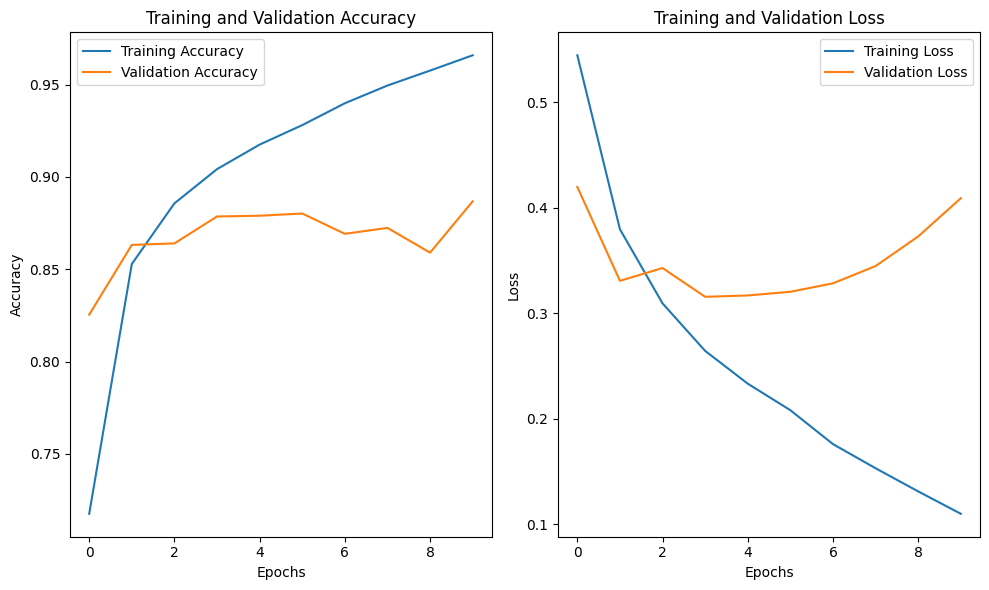

In [ ]:
import matplotlib.pyplot as plt
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(History.history['accuracy'], label='Training Accuracy')
plt.plot(History.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(History.history['loss'], label='Training Loss')
plt.plot(History.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

###Question 1

In [ ]:
max_length_150 = 150
text_vectorization_150 = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length_150, #This ensure the review is turncated to exactly 150 tokens
)
text_vectorization_150.adapt(text_only_train_ds)

# Apply vectorization to train, validation, and test datasets
int_train_ds_150 = train_ds.map(
    lambda x, y: (text_vectorization_150(x), y),
    num_parallel_calls=4)
int_val_ds_150 = val_ds.map(
    lambda x, y: (text_vectorization_150(x), y),
    num_parallel_calls=4)
int_test_ds_150 = test_ds.map(  # Apply the same vectorization to test data
    lambda x, y: (text_vectorization_150(x), y),
    num_parallel_calls=4)


# Define the model
model_cutoff_150 = tf.keras.Sequential([
    layers.Embedding(max_tokens, 128, input_length=max_length_150),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

# Compile the model
model_cutoff_150.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

checkpoint_callback = keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm_150.keras", save_best_only=True)

history_150 = model_cutoff_150.fit(
    int_train_ds_150,
    validation_data=int_val_ds_150,
    epochs=10,
    callbacks=[checkpoint_callback]
)

# Evaluate and print accuracy on the test dataset
print(f"Test acc: {model_cutoff_150.evaluate(int_test_ds_150)[1]:.3f}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.6218 - loss: 0.6185 - val_accuracy: 0.8156 - val_loss: 0.4375
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8401 - loss: 0.3920 - val_accuracy: 0.8530 - val_loss: 0.3452
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8760 - loss: 0.3149 - val_accuracy: 0.8514 - val_loss: 0.3562
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8987 - loss: 0.2673 - val_accuracy: 0.8408 - val_loss: 0.3906
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9162 - loss: 0.2241 - val_accuracy: 0.8570 - val_loss: 0.3798
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9342 - loss: 0.1877 - val_accuracy: 0.8632 - val_loss: 0.3956
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9464 - loss: 0.1504 - val_accuracy: 0.8572 - val_loss: 0.4169
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9562 - loss: 0.1270 - val_accurac

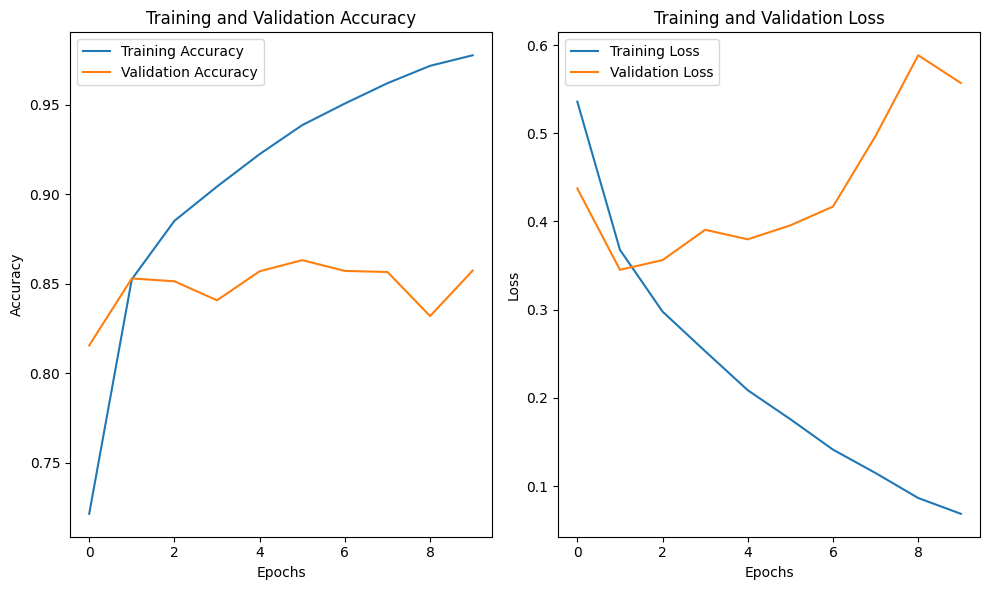

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_150.history['accuracy'], label='Training Accuracy')
plt.plot(history_150.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_150.history['loss'], label='Training Loss')
plt.plot(history_150.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Question 2

In [ ]:
int_train_ds_small = int_train_ds.take(100) # Limit training samples to 100

# Define model
model_100_samples = tf.keras.Sequential([
    layers.Embedding(max_tokens, 128, input_length=max_length),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

model_100_samples.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model and capture the training history
history_100_samples = model_100_samples.fit(
    int_train_ds_small,
    validation_data=int_val_ds,
    epochs=10
)

print(f"Test acc: {model_100_samples.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.5092 - loss: 0.6937 - val_accuracy: 0.5128 - val_loss: 0.6890
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5737 - loss: 0.6711 - val_accuracy: 0.6834 - val_loss: 0.5954
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.7445 - loss: 0.5503 - val_accuracy: 0.7728 - val_loss: 0.4980
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8103 - loss: 0.4382 - val_accuracy: 0.7502 - val_loss: 0.5722
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.8594 - loss: 0.3698 - val_accuracy: 0.8050 - val_loss: 0.4549
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9058 - loss: 0.2615 - val_accuracy: 0.7668 - val_loss: 0.5483
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9155 - loss: 0.2306 - val_accuracy: 0.8022 - val_loss: 0.5481
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9611 - loss: 0.1415 - val_accu

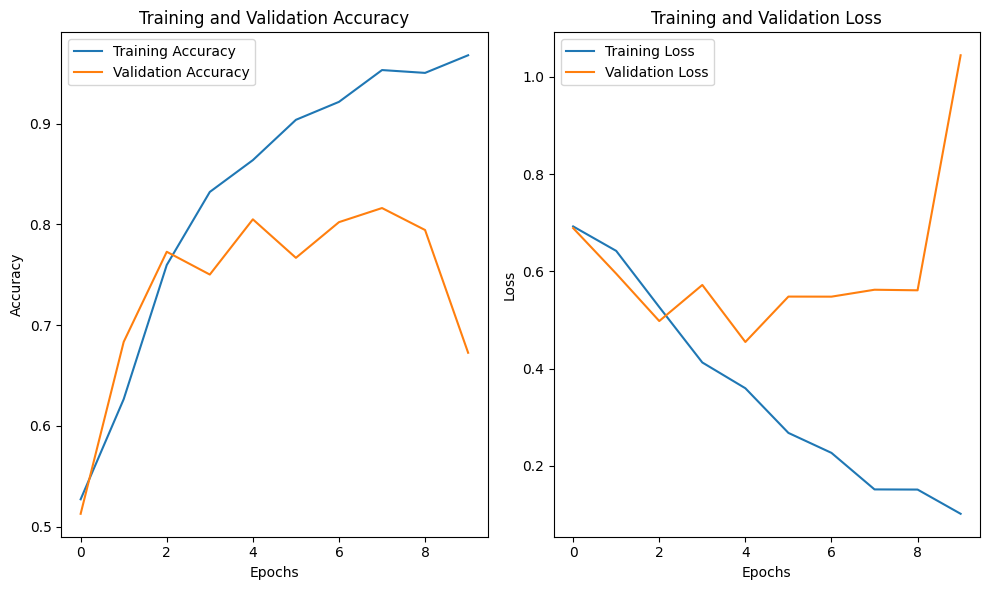

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_100_samples.history['accuracy'], label='Training Accuracy')
plt.plot(history_100_samples.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_100_samples.history['loss'], label='Training Loss')
plt.plot(history_100_samples.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Question 3

In [ ]:
# Limit validation dataset to 10,000 samples
int_val_ds_10k = int_val_ds.take(10000)

# Define model
model_validate_10k = tf.keras.Sequential([
    layers.Embedding(max_tokens, 128, input_length=max_length),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

# Compile the model
model_validate_10k.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

history_validate_10k = model_validate_10k.fit(
    int_train_ds,
    validation_data=int_val_ds_10k,
    epochs=10
)

# Evaluate and print accuracy on the test dataset
print(f"Test acc: {model_validate_10k.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.6348 - loss: 0.6222 - val_accuracy: 0.8244 - val_loss: 0.4143
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.8263 - loss: 0.4159 - val_accuracy: 0.8306 - val_loss: 0.4072
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.8783 - loss: 0.3284 - val_accuracy: 0.8630 - val_loss: 0.3355
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.8993 - loss: 0.2760 - val_accuracy: 0.8644 - val_loss: 0.3202
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.9138 - loss: 0.2448 - val_accuracy: 0.8812 - val_loss: 0.3038
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.9267 - loss: 0.2158 - val_accuracy: 0.8602 - val_loss: 0.3839
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.9332 - loss: 0.1958 - val_accuracy: 0.8648 - val_loss: 0.3470
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.9485 - loss: 0.1570 - 

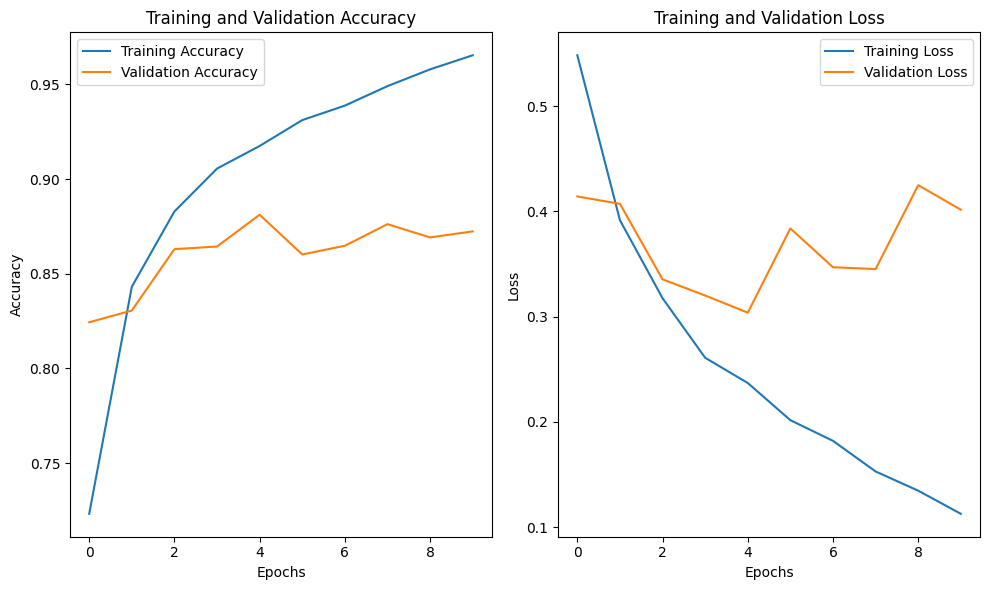

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_validate_10k.history['accuracy'], label='Training Accuracy')
plt.plot(history_validate_10k.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_validate_10k.history['loss'], label='Training Loss')
plt.plot(history_validate_10k.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Question 4

In [ ]:
# Adjust max_tokens to 10,000
max_tokens_10k = 10000
text_vectorization_10k = layers.TextVectorization(
    max_tokens=max_tokens_10k,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization_10k.adapt(text_only_train_ds)

# Transform datasets with the updated vectorizer
int_train_ds_10k = train_ds.map(
    lambda x, y: (text_vectorization_10k(x), y),
    num_parallel_calls=4)
int_val_ds_10k = val_ds.map(
    lambda x, y: (text_vectorization_10k(x), y),
    num_parallel_calls=4)
int_test_ds_10k = test_ds.map(
    lambda x, y: (text_vectorization_10k(x), y),
    num_parallel_calls=4)

# Define model
model_top_10k = tf.keras.Sequential([
    layers.Embedding(max_tokens_10k, 128, input_length=max_length),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

# Compile the model
model_top_10k.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model and capture the training history
history_top_10k = model_top_10k.fit(
    int_train_ds_10k,
    validation_data=int_val_ds_10k,
    epochs=10
)

# Evaluate and print accuracy on the test dataset
print(f"Test acc: {model_top_10k.evaluate(int_test_ds_10k)[1]:.3f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.6208 - loss: 0.6252 - val_accuracy: 0.8274 - val_loss: 0.4181
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.8323 - loss: 0.4186 - val_accuracy: 0.8306 - val_loss: 0.4188
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.8672 - loss: 0.3482 - val_accuracy: 0.7608 - val_loss: 0.5143
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.8854 - loss: 0.3044 - val_accuracy: 0.8616 - val_loss: 0.3318
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.9019 - loss: 0.2704 - val_accuracy: 0.8132 - val_loss: 0.6718
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.9182 - loss: 0.2361 - val_accuracy: 0.8690 - val_loss: 0.3250
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.9219 - loss: 0.2129 - val_accuracy: 0.8568 - val_loss: 0.3790
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.9363 - loss: 0.1908 - 

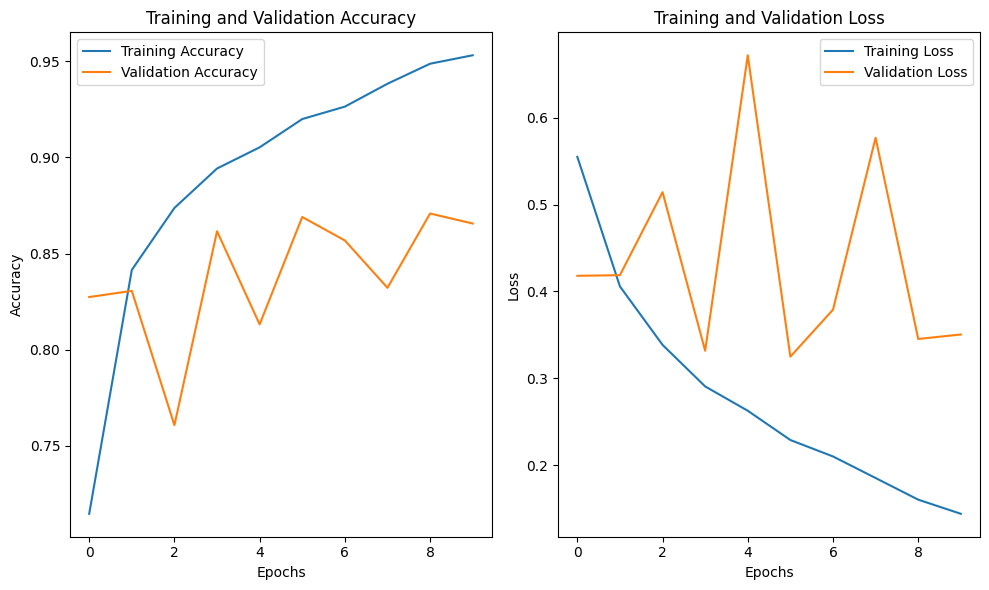

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_top_10k.history['accuracy'], label='Training Accuracy')
plt.plot(history_top_10k.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_top_10k.history['loss'], label='Training Loss')
plt.plot(history_top_10k.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Question 5

Preparing pre trained model

In [ ]:
import os
import tarfile
import urllib.request
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import initializers

# Step 1: Download the dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
file_name = "aclImdb_v1.tar.gz"
urllib.request.urlretrieve(url, file_name)

# Step 2: Extract the tar.gz file
if file_name.endswith("tar.gz"):
    with tarfile.open(file_name, "r:gz") as tar:
        tar.extractall()

# Step 3: Remove the 'unsup' directory (Windows-compatible)
unsup_dir = "aclImdb/train/unsup"
if os.path.exists(unsup_dir):
    import shutil
    shutil.rmtree(unsup_dir)

print("Dataset downloaded, extracted, and 'unsup' directory removed.")

# Step 4: Load GloVe embeddings
path_to_glove_file = "glove.6B.100d.txt"
embeddings_index = {}
if os.path.exists(path_to_glove_file):
    with open(path_to_glove_file, encoding="utf-8") as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    print(f"Found {len(embeddings_index)} word vectors.")
else:
    print("GloVe embeddings file not found. Please download it and place it in the working directory.")

# Step 5: Prepare vocabulary and embedding matrix
# Example TextVectorization layer
max_tokens = 20000  # Maximum number of words in the vocabulary
max_length = 200  # Maximum length of input sequences
text_vectorization = layers.TextVectorization(max_tokens=max_tokens, output_sequence_length=max_length)

# Simulating a vocabulary (replace with your actual vocabulary from `text_vectorization`)
vocabulary = ["the", "and", "movie", "good", "bad", "great"]  # Example
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Initialize embedding matrix
embedding_dim = 100  # Must match the GloVe file dimension
embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Step 6: Define embedding layers
# a) Embedding layer with learned embeddings
embedding_layer_trained = layers.Embedding(
    max_tokens,
    embedding_dim,
    input_length=max_length
)

# b) Pretrained embedding layer using GloVe (frozen)
embedding_layer_pretrained = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=initializers.Constant(embedding_matrix),
    trainable=False,  # Freeze embeddings
    mask_zero=True
)

print("Embedding layers defined.")


Dataset downloaded, extracted, and 'unsup' directory removed.
GloVe embeddings file not found. Please download it and place it in the working directory.
Embedding layers defined.


In [ ]:
# Define the model with the learned embedding layer
inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = embedding_layer_trained(inputs)  # Trained embedding
x = layers.Bidirectional(layers.LSTM(32))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_trained = tf.keras.Model(inputs, outputs)
model_trained.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model and capture the training history
history_trained = model_trained.fit(int_train_ds, validation_data=int_val_ds, epochs=10)

# Evaluate and print accuracy on the test dataset
print(f"Test acc (Trained Embedding): {model_trained.evaluate(int_test_ds)[1]:.3f}")


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.6278 - loss: 0.6228 - val_accuracy: 0.8524 - val_loss: 0.3757
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.8431 - loss: 0.4032 - val_accuracy: 0.8380 - val_loss: 0.3791
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.8789 - loss: 0.3222 - val_accuracy: 0.8686 - val_loss: 0.3168
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.8991 - loss: 0.2825 - val_accuracy: 0.8546 - val_loss: 0.3673
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.9164 - loss: 0.2399 - val_accuracy: 0.8764 - val_loss: 0.3155
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.9240 - loss: 0.2215 - val_accuracy: 0.8818 - val_loss: 0.3310
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.9335 - loss: 0.1926 - val_accuracy: 0.8648 - val_loss: 0.3466
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - accuracy: 0.9351 - loss: 0.1794 - 

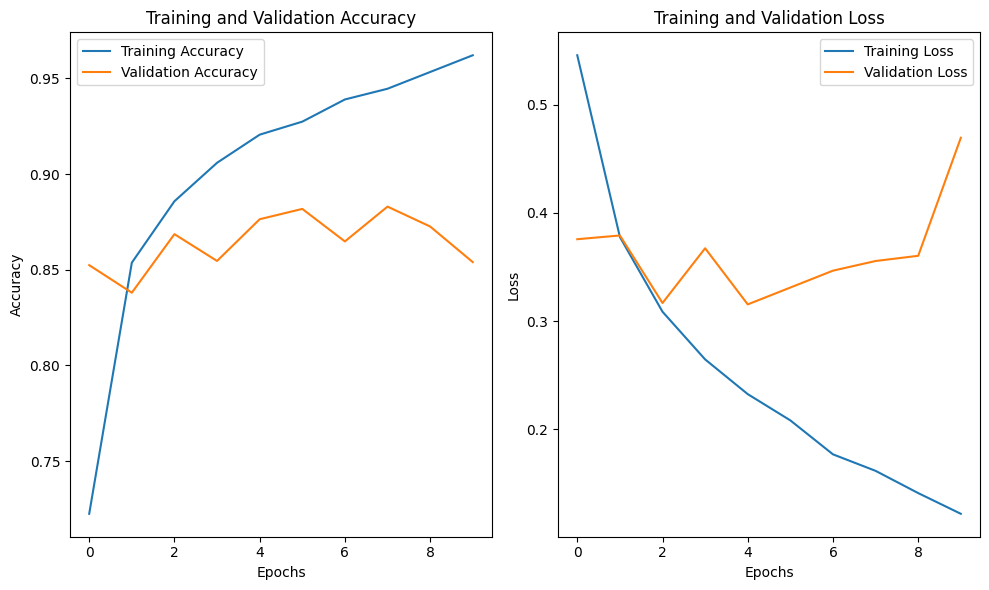

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_trained.history['accuracy'], label='Training Accuracy')
plt.plot(history_trained.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_trained.history['loss'], label='Training Loss')
plt.plot(history_trained.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import requests
import zipfile
import os

# Download the file
url = "http://nlp.stanford.edu/data/glove.6B.zip"
output_path = "glove.6B.zip"

print("Downloading Glove embeddings...")
response = requests.get(url)
with open(output_path, "wb") as file:
    file.write(response.content)

# Extract the zip file
print("Extracting the zip file...")
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall(".")

# Cleanup: Optional
os.remove(output_path)
print("Download and extraction complete.")


Extracting the zip file...
Download and extraction complete.


In [ ]:
import numpy as np

# Path to the GloVe embeddings file
path_to_glove_file = "glove.6B.100d.txt"  # Update the path if needed

# Dictionary to store word embeddings
embeddings_index = {}

try:
    print("Loading GloVe embeddings...")
    with open(path_to_glove_file, encoding="utf-8") as f:
        for line in f:
            # Split each line into the word and its coefficients
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")  # Convert coefficients to numpy array
            embeddings_index[word] = coefs  # Add to dictionary

    print(f"Found {len(embeddings_index)} word vectors.")
except FileNotFoundError:
    print(f"Error: File not found at {path_to_glove_file}. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")


Loading GloVe embeddings...
Found 400000 word vectors.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np

# Parameters
max_tokens = 20000  # Adjust according to your dataset/vocabulary size
embedding_dim = 100  # Dimension of GloVe embeddings
batch_size = 32  # Adjust batch size according to your system

# Step 1: Load GloVe embeddings
embeddings_index = {}
path_to_glove_file = "glove.6B.100d.txt"
with open(path_to_glove_file, encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print(f"Found {len(embeddings_index)} word vectors.")

# Step 2: Load your dataset (using keras text_dataset_from_directory)
train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

# Step 3: Prepare the TextVectorization layer
# Extract texts from train_ds (text data)
train_texts = train_ds.map(lambda x, y: x)  # Extract only the texts
text_vectorization = layers.TextVectorization(max_tokens=max_tokens)
text_vectorization.adapt(train_texts)  # Adapt to your training data

# Prepare the embedding matrix
vocabulary = text_vectorization.get_vocabulary()  # Vocabulary from your dataset
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Step 4: Define the embedding layer
embedding_layer_pretrained = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,  # Freeze GloVe weights
    mask_zero=True,  # Optional: Mask padding tokens
)

# Step 5: Preprocess and prepare the datasets
def vectorize_text(text, label):
    return text_vectorization(text), label

train_ds = train_ds.map(vectorize_text).cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(vectorize_text).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(vectorize_text).cache().prefetch(tf.data.AUTOTUNE)

# Step 6: Build the model
inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = embedding_layer_pretrained(inputs)  # Use pretrained GloVe embeddings
x = layers.Bidirectional(layers.LSTM(32))(x)  # Bidirectional LSTM
x = layers.Dropout(0.5)(x)  # Dropout layer
outputs = layers.Dense(1, activation="sigmoid")(x)  # Output layer for binary classification

model_pretrained = tf.keras.Model(inputs, outputs)

# Step 7: Compile the model
model_pretrained.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),  # Adjust learning rate
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Step 8: Train the model
history_pretrained = model_pretrained.fit(
    train_ds,  # Training dataset (tokenized and batched)
    validation_data=val_ds,  # Validation dataset
    epochs=10  # Number of epochs
)

# Step 9: Evaluate the model
test_loss, test_acc = model_pretrained.evaluate(test_ds)  # Test dataset
print(f"Test Accuracy (Pretrained Embedding): {test_acc:.3f}")


Found 400000 word vectors.
Found 25000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5381 - loss: 0.6944 - val_accuracy: 0.6824 - val_loss: 0.6105
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.6840 - loss: 0.6077 - val_accuracy: 0.7384 - val_loss: 0.5394
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.7304 - loss: 0.5501 - val_accuracy: 0.7770 - val_loss: 0.4778
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - accuracy: 0.7637 - loss: 0.5087 - val_accuracy: 0.7918 - val_loss: 0.4545
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.7707 - loss: 0.4873 - val_accuracy: 0.8006 - val_loss: 0.4385
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.7793 - loss: 0.4751 - val_accuracy: 0.8080 - val_loss: 0.4256
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.

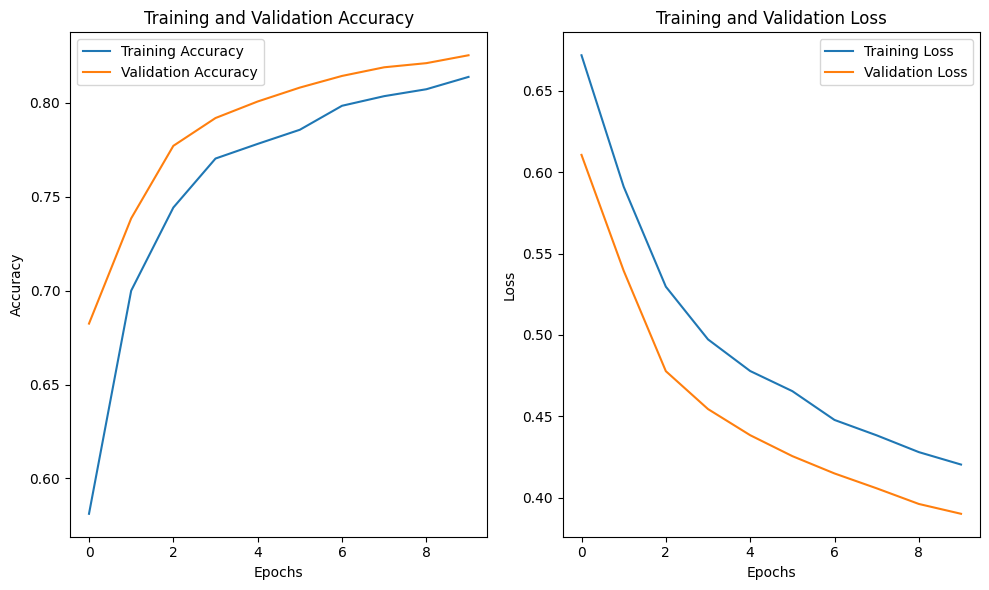

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_pretrained.history['accuracy'], label='Training Accuracy')
plt.plot(history_pretrained.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_pretrained.history['loss'], label='Training Loss')
plt.plot(history_pretrained.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Increasing Values

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.5037 - loss: 0.7074 - val_accuracy: 0.5214 - val_loss: 0.6885
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.5400 - loss: 0.6846 - val_accuracy: 0.5612 - val_loss: 0.6788
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.5720 - loss: 0.6725 - val_accuracy: 0.5858 - val_loss: 0.6722
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.6078 - loss: 0.6566 - val_accuracy: 0.5334 - val_loss: 0.7125
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.6231 - loss: 0.6483 - val_accuracy: 0.6378 - val_loss: 0.6352
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.6212 - loss: 0.6408 - val_accuracy: 0.6406 - val_loss: 0.6353
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.6437 - loss: 0.6186 - val_accuracy: 0.6264 - val_loss: 0.6420
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6765 - loss: 0.5946 - val_accu

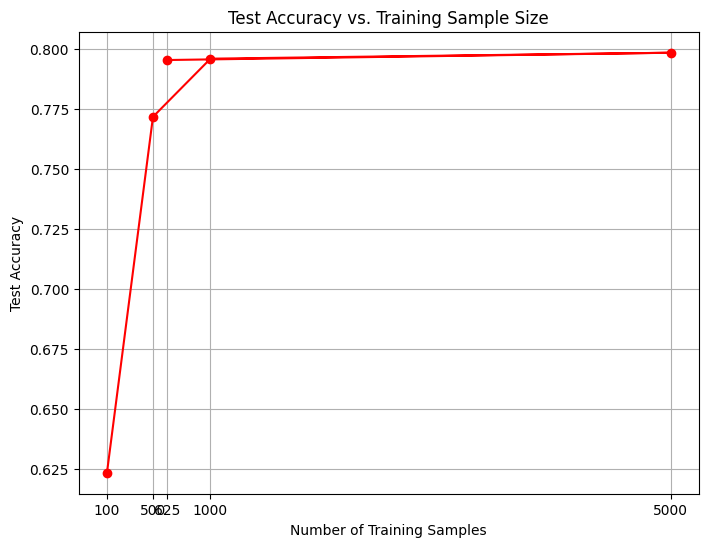

In [ ]:
# Define a list of different training sample sizes to test
training_sizes = [100, 500, 1000, 5000, len(int_train_ds)]  # Add the total number of training samples at the end

# Initialize variables to store test accuracy for each training size
test_accuracies = []

for size in training_sizes:
    # Take a subset of the training dataset based on the current size
    subset_train_ds = int_train_ds.take(size)

    # Define the model with the embedding layer (use either learned or pretrained)
    inputs = tf.keras.Input(shape=(None,), dtype="int64")
    x = embedding_layer_pretrained(inputs)  # Use pretrained embedding layer (GloVe) or embedding_layer_trained
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

    # Train the model with the current subset of training data
    model.fit(subset_train_ds, validation_data=int_val_ds, epochs=10)

    # Evaluate the model on the test dataset and store the test accuracy
    test_accuracy = model.evaluate(int_test_ds)[1]
    test_accuracies.append(test_accuracy)

    # Print the test accuracy for the current training size
    print(f"Training samples: {size}, Test accuracy: {test_accuracy:.3f}")

# Print out the test accuracies for all training sizes
print("\nTest accuracies for different training sizes:")
for size, accuracy in zip(training_sizes, test_accuracies):
    print(f"Training size: {size}, Test accuracy: {accuracy:.3f}")

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(training_sizes, test_accuracies, marker='o', linestyle='-', color='red')
plt.title("Test Accuracy vs. Training Sample Size")
plt.xlabel("Number of Training Samples")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.xticks(training_sizes)  # Ensure all training sizes are shown on the x-axis
plt.show()